In [11]:
# Import libraries
import numpy as np
import pandas as pd
from obspy import read
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import os
from scipy import signal
from matplotlib import cm
from obspy.signal.invsim import cosine_taper
from obspy.signal.filter import highpass
from obspy.signal.trigger import classic_sta_lta, trigger_onset

In [12]:
cat_directory = '../data/lunar/training/catalogs/'
cat_file = cat_directory + 'apollo12_catalog_GradeA_final.csv'
cat = pd.read_csv(cat_file)
cat

,filename,time_abs(%Y-%m-%dT%H:%M:%S.%f),time_rel(sec),evid,mq_type
0,xa.s12.00.mhz.1970-01-19HR00_evid00002,1970-01-19T20:25:00.000000,73500.0,evid00002,impact_mq
1,xa.s12.00.mhz.1970-03-25HR00_evid00003,1970-03-25T03:32:00.000000,12720.0,evid00003,impact_mq
2,xa.s12.00.mhz.1970-03-26HR00_evid00004,1970-03-26T20:17:00.000000,73020.0,evid00004,impact_mq
3,xa.s12.00.mhz.1970-04-25HR00_evid00006,1970-04-25T01:14:00.000000,4440.0,evid00006,impact_mq
4,xa.s12.00.mhz.1970-04-26HR00_evid00007,1970-04-26T14:29:00.000000,52140.0,evid00007,deep_mq
...,...,...,...,...,...
71,xa.s12.00.mhz.1974-10-14HR00_evid00156,1974-10-14T17:43:00.000000,63780.0,evid00156,impact_mq
72,xa.s12.00.mhz.1975-04-12HR00_evid00191,1975-04-12T18:15:00.000000,65700.0,evid00191,impact_mq
73,xa.s12.00.mhz.1975-05-04HR00_evid00192,1975-05-04T10:05:00.000000,36300.0,evid00192,impact_mq
74,xa.s12.00.mhz.1975-06-24HR00_evid00196,1975-06-24T16:03:00.000000,57780.0,evid00196,impact_mq


In [13]:
row = cat.iloc[20]
arrival_time = datetime.strptime(row['time_abs(%Y-%m-%dT%H:%M:%S.%f)'],'%Y-%m-%dT%H:%M:%S.%f')
arrival_time

datetime.datetime(1971, 4, 13, 12, 55)

In [14]:
# If we want the value of relative time, we don't need to use datetime
arrival_time_rel = row['time_rel(sec)']
arrival_time_rel

46500.0

In [15]:
# Let's also get the name of the file
test_filename = row.filename
test_filename

'xa.s12.00.mhz.1971-04-13HR00_evid00029'

In [17]:
data_directory = '../data/lunar/training/data/S12_GradeA/xa.s12.00.mhz.1971-04-13HR02_evid00029.mseed'
mseed_file = f'{data_directory}{test_filename}.mseed'
st = read(data_directory)
st

1 Trace(s) in Stream:
XA.S12.00.MHZ | 1971-04-13T02:42:48.990062Z - 1971-04-13T22:37:34.122137Z | 6.6 Hz, 474915 samples

In [18]:
tr = st.traces[0].copy()
tr_times = tr.times()
tr_data = tr.data

# Start time of trace (another way to get the relative arrival time using datetime)
starttime = tr.stats.starttime.datetime
arrival = (arrival_time - starttime).total_seconds()
arrival

36731.009938

In [19]:
# Set the minimum frequency
minfreq = 0.5
maxfreq = 1.0

# Going to create a separate trace for the filter data
st_filt = st.copy()
st_filt.filter('bandpass',freqmin=minfreq,freqmax=maxfreq)
tr_filt = st_filt.traces[0].copy()
tr_times_filt = tr_filt.times()
tr_data_filt = tr_filt.data

In [20]:
f, t, sxx = signal.spectrogram(tr_data_filt, tr_filt.stats.sampling_rate)

Arrival time: 36731.009938


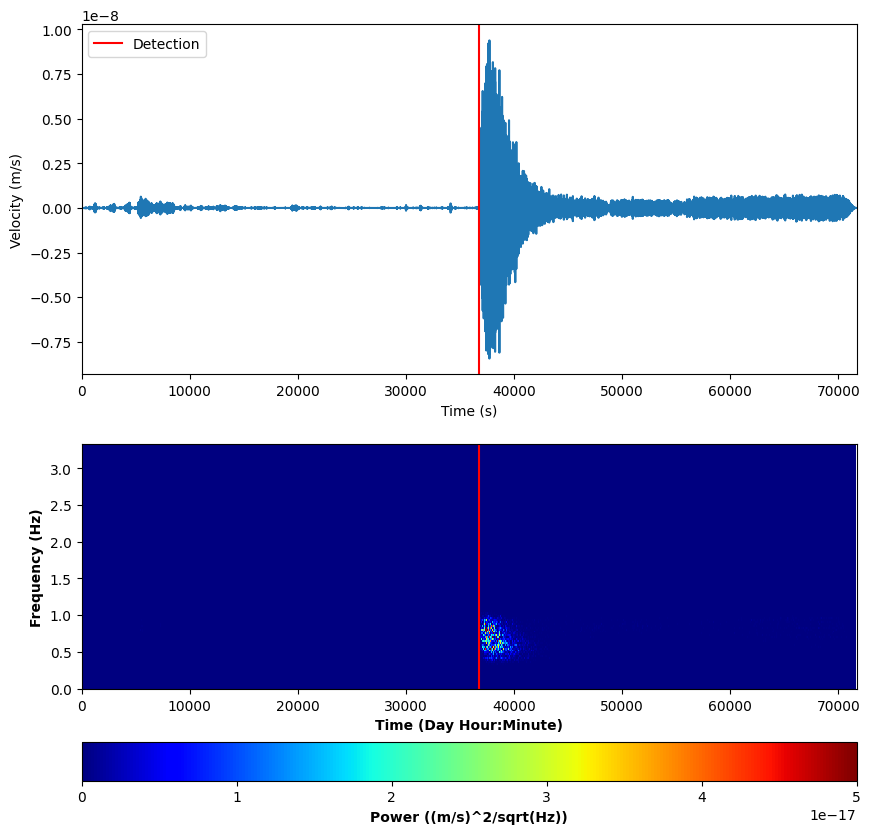

In [21]:
# Plot the time series and spectrogram
fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(2, 1, 1)
# Plot trace
ax.plot(tr_times_filt,tr_data_filt)

# Mark detection
ax.axvline(x = arrival, color='red',label='Detection')
ax.legend(loc='upper left')
print(f'Arrival time: {arrival}')
# Make the plot pretty
ax.set_xlim([min(tr_times_filt),max(tr_times_filt)])
ax.set_ylabel('Velocity (m/s)')
ax.set_xlabel('Time (s)')

ax2 = plt.subplot(2, 1, 2)
vals = ax2.pcolormesh(t, f, sxx, cmap=cm.jet, vmax=5e-17)
ax2.set_xlim([min(tr_times_filt),max(tr_times_filt)])
ax2.set_xlabel(f'Time (Day Hour:Minute)', fontweight='bold')
ax2.set_ylabel('Frequency (Hz)', fontweight='bold')
ax2.axvline(x=arrival, c='red')
cbar = plt.colorbar(vals, orientation='horizontal')
cbar.set_label('Power ((m/s)^2/sqrt(Hz))', fontweight='bold')

# V3

c:\Users\hombr\AppData\Local\Programs\Python\Python312\Lib\site-packages\obspy\signal\filter.py:62: UserWarning: Selected high corner frequency (10.0) of bandpass is at or above Nyquist (3.3125). Applying a high-pass instead.
  warnings.warn(msg)


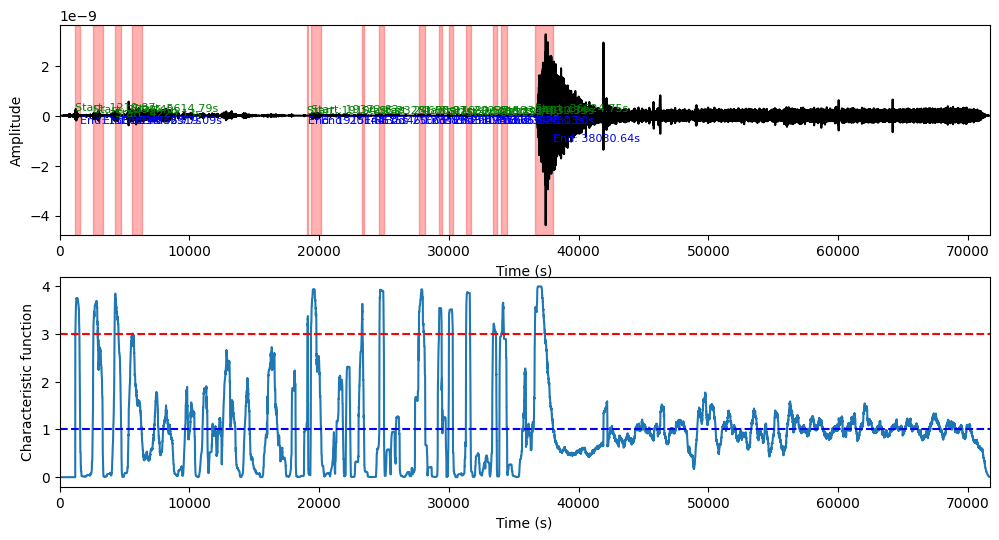

In [22]:
from obspy.signal.trigger import classic_sta_lta, trigger_onset
import matplotlib.pyplot as plt

# Frecuencia de muestreo de la traza
df = tr.stats.sampling_rate

# Aplicar un filtro de banda antes del análisis (opcional)
tr.filter('bandpass', freqmin=1.0, freqmax=10.0)

# Longitudes de ventana STA/LTA en segundos (ajustadas)
sta_len = 300  # Ventana de corto plazo, incrementada para suavizar la respuesta
lta_len = 1200  # Ventana de largo plazo, incrementada para suavizar la respuesta

# Ejecutar STA/LTA clásico
cft = classic_sta_lta(tr.data, int(sta_len * df), int(lta_len * df))

# Definir umbrales para la detección (ajustados)
threshold_on = 3.0  # Incrementar umbral de activación
threshold_off = 1.0  # Ajustar umbral de desactivación

# Detectar eventos
on_off = trigger_onset(cft, threshold_on, threshold_off)

# Fusionar detecciones cercanas (si la diferencia entre ellas es menor a un cierto tiempo)
min_gap = 1000  # Número de muestras entre eventos detectados para fusionarlos
merged_on_off = []
current_event = on_off[0]
for i in range(1, len(on_off)):
    if on_off[i][0] - current_event[1] < min_gap:
        current_event[1] = on_off[i][1]  # Fusionar eventos
    else:
        merged_on_off.append(current_event)
        current_event = on_off[i]
merged_on_off.append(current_event)

# Visualizar la función característica y las detecciones
fig, ax = plt.subplots(2, 1, figsize=(12, 6))

# Gráfico de la señal con detecciones
ax[0].plot(tr.times(), tr.data, 'k')
for start, end in merged_on_off:
    # Convertir índices a tiempo en segundos
    start_time = start / df
    end_time = end / df
    
    # Resaltar el intervalo detectado
    ax[0].axvspan(tr.times()[start], tr.times()[end], color='red', alpha=0.3)
    
    # Anotar el tiempo de inicio y fin
    ax[0].text(tr.times()[start], tr.data[start], f'Start: {start_time:.2f}s', color='green', fontsize=8, verticalalignment='bottom')
    ax[0].text(tr.times()[end], tr.data[end], f'End: {end_time:.2f}s', color='blue', fontsize=8, verticalalignment='top')

ax[0].set_xlim([min(tr.times()), max(tr.times())])
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('Amplitude')

# Gráfico de la función característica STA/LTA
ax[1].plot(tr.times(), cft)
ax[1].axhline(y=threshold_on, color='r', linestyle='--')
ax[1].axhline(y=threshold_off, color='b', linestyle='--')
ax[1].set_xlim([min(tr.times()), max(tr.times())])
ax[1].set_xlabel('Time (s)')
ax[1].set_ylabel('Characteristic function')

plt.show()

# V2

In [23]:
i=0
for start_test,end_test in merged_on_off:
    i+=1
    print(f'{i}. Event detected at {start_test/df} s and ended at {end_test/df} s')

1. Event detected at 1210.867924528302 s and ended at 1581.7358490566037 s
2. Event detected at 2599.396226415094 s and ended at 3314.4150943396226 s
3. Event detected at 4229.132075471698 s and ended at 4755.773584905661 s
4. Event detected at 5614.792452830188 s and ended at 6319.094339622641 s
5. Event detected at 19104.150943396227 s and ended at 19151.849056603773 s
6. Event detected at 19372.830188679247 s and ended at 20144.754716981133 s
7. Event detected at 23281.056603773584 s and ended at 23460.22641509434 s
8. Event detected at 24650.867924528302 s and ended at 25005.88679245283 s
9. Event detected at 27680.603773584906 s and ended at 28181.735849056604 s
10. Event detected at 29237.584905660377 s and ended at 29496.0 s
11. Event detected at 30006.490566037737 s and ended at 30313.66037735849 s
12. Event detected at 31325.735849056604 s and ended at 31675.924528301886 s
13. Event detected at 33413.43396226415 s and ended at 33685.1320754717 s
14. Event detected at 34030.792